<a href="https://colab.research.google.com/github/KaissonFerreira/teste/blob/main/Projeto/Desafio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

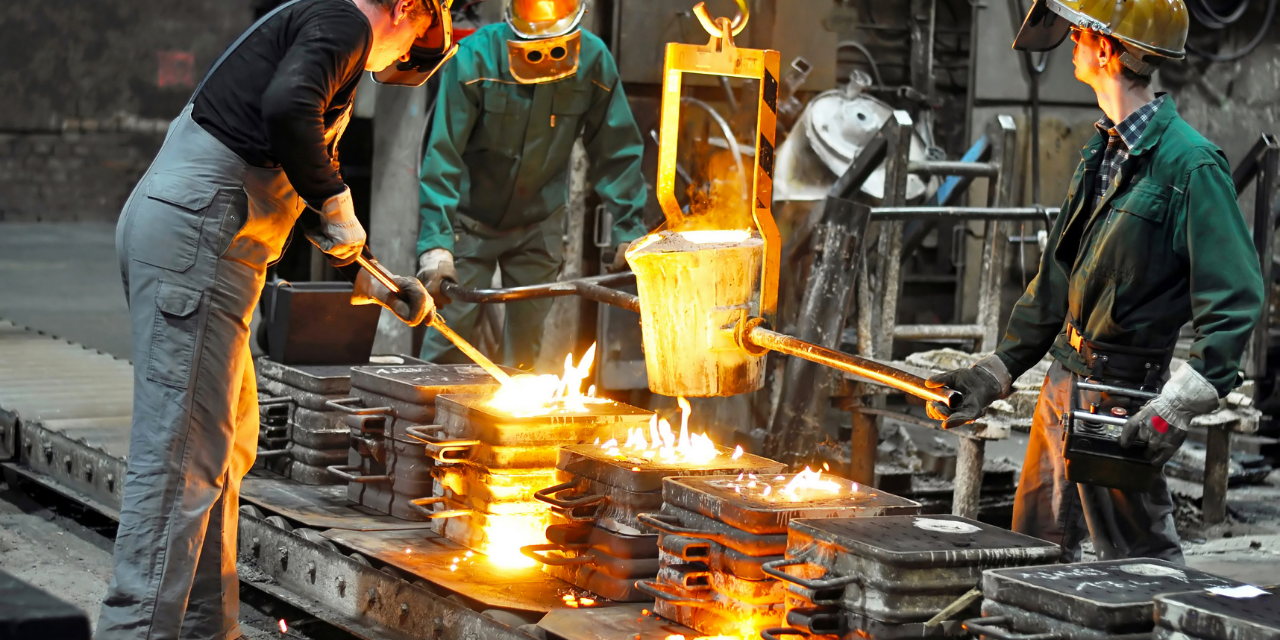

# CASE TÉCNICO


---
O recozimento é um tratamento térmico que tem por finalidade eliminar a dureza de uma peça temperada ou normalizar materiais com tensões internas resultantes do forjamento, da laminação, da trefilação. De acordo com o novo nível de dureza do material tratado, o resultado do processo de recozimento pode ser classificado como: ideal, mediano ou ruim.

O conjunto de dados apresentado traz o resultado da execução de diferentes processos de recozimento em experimentos variados.
Assim sendo, o candidato deve realizar tratamentos e análises sobre os dados para entender quais são os principais fatores que podem lavar a um bom modelo de classificação para predizer o resultado de novos processos de recozimento.



---
**Estrutura do projeto**
* Conhecimento sobre o contexto de negócio
* Extração
* Tratamento
* Análise exploratória (geração de insights e seleção de Features)
* Pré-Processamento
* Treino e Validação do modelo de ML


## Extração

---
Nessa fase, serão importadas as bibliotecas que serão utilizadas no decorrer do projeto, será realizada a extração dos dados e também uma breve visualização sobre a disposição dos dados para um tratamento posterior.

**OBS: Após a realização de uma análise exploratória minuciosa, o autor do projeto se sentiu extramamente curioso para saber como seria as predições com os modelos de ML. Por isso, alguns modelos foram testados nesse projeto, mesmo que essa tarefa não tenha sido pedida na proposta do desafio.**


Importando bibliotecas para análise exploratória

In [55]:
# Biblioteca de modelagem
import pandas as pd
import numpy as np

# Visualização gráfica
import matplotlib.pyplot as plt
import seaborn as sns

# Pré-Processamento
from sklearn.preprocessing import MinMaxScaler

# Divisão de treino e teste de forma estratificada
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score #Função que auxilia no processo de validação do modelo

# modelos de machine learning
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# Métricas
from sklearn.metrics import plot_confusion_matrix,plot_roc_curve,classification_report


In [56]:
# Extraindo arquivos
url_data = 'https://github.com/KaissonFerreira/teste/raw/main/data_experimentos.csv'
url_train = 'https://github.com/KaissonFerreira/teste/raw/main/train.csv'
df_data = pd.read_csv(url_data)
df_train = pd.read_csv(url_train)

Conferindo o carregamento dos dados nos Dataframes:

In [57]:
# Primeiro Dataframe
df_data.tail() # Últimas 5 linhas

,exp_id,ano,mes
2419,1354,2020,7
2420,1610,2020,7
2421,2243,2020,7
2422,900,2020,7
2423,534,2020,7


In [58]:
# Segundo DataFrame
df_train.tail() # Últimas 5 linhas

,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw/me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,blue/bright/varn/clean,lustre,jurofm,s,p,shape,thick,width,len,oil,bore,packing,recozimento,experimento
2419,?,C,R,0,0,?,S,2.0,0,?,?,?,?,?,?,?,?,Y,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.6_,_1500.0_,_4170_,?,0,?,mediano,exp_1354
2420,TN,C,A,0,0,?,?,3.0,0,N,?,?,?,?,?,?,?,?,?,C,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.2_,_609.9_,_1_,?,0,?,mediano,exp_1610
2421,?,C,R,0,0,?,S,3.0,0,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.601_,_830.0_,_880_,?,0,?,mediano,exp_2243
2422,?,C,A,0,85,T,?,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_0.4_,_20.0_,_0_,?,0,?,mediano,exp_900
2423,?,C,A,0,85,T,?,?,0,?,?,G,?,?,?,Y,M,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_4.0_,_610.0_,_0_,?,500,?,mediano,exp_534


Ao visualizar as últimas 5 linhas, percebe-se que os dois DataFrames tem a mesma quantidade de registros.
Vale Ressaltar que **somente experimentos realizados em agosto de 2020 devem ser considerados**, de acordo com a proposta do Desafio.

## Tratamento dos dados:

### Entendendo os tipos de dados

Para fazer a união dos dois DataFrames pela chave experimento/exp_id, primeiro iremos renomear uma dessas colunas pelo nome da outra, transformar a coluna experimento df_train em tipo int64, e em seguida, aplicar o método merge() do Pandas. 

In [59]:
# Tipos de dados de df_train
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2424 entries, 0 to 2423
Data columns (total 40 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   family                  2424 non-null   object
 1   product-type            2424 non-null   object
 2   steel                   2424 non-null   object
 3   carbon                  2424 non-null   int64 
 4   hardness                2424 non-null   int64 
 5   temper_rolling          2424 non-null   object
 6   condition               2424 non-null   object
 7   formability             2424 non-null   object
 8   strength                2424 non-null   int64 
 9   non-ageing              2424 non-null   object
 10  surface-finish          2424 non-null   object
 11  surface-quality         2424 non-null   object
 12  enamelability           2424 non-null   object
 13  bc                      2424 non-null   object
 14  bf                      2424 non-null   object
 15  bt  

In [60]:
# Separando a coluna experimento em duas e renomeando a coluna int com o nome da coluna do Dataframe df_data
df_train[['str','exp_id']]=df_train['experimento'].str.split("_",expand=True)

In [61]:
# Exclusão das colunas que não precisa
df_train = df_train.drop(columns=['experimento','str'],axis=1)
# Transformando a coluna produzida em int
df_train['exp_id']=df_train['exp_id'].astype(int)
df_train.head(1)

,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw/me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,blue/bright/varn/clean,lustre,jurofm,s,p,shape,thick,width,len,oil,bore,packing,recozimento,exp_id
0,?,C,A,8,0,?,S,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_0.7_,_610.0_,_0_,?,0,?,ruim,2


In [62]:
# União dos Dataframes com o parâmetro 'how = outer', uma vez queremos unir TODOS os dados.
df = pd.merge(df_data,df_train,how ='outer',
              on= 'exp_id')
df.head()

,exp_id,ano,mes,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw/me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,blue/bright/varn/clean,lustre,jurofm,s,p,shape,thick,width,len,oil,bore,packing,recozimento
0,2,2020,8,?,C,A,8,0,?,S,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_0.7_,_610.0_,_0_,?,0,?,ruim
1,1368,2020,8,?,C,R,0,0,?,S,2.0,0,?,?,E,?,?,Y,?,B,?,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_0.7_,_1300.0_,_762_,?,0,?,ruim
2,1130,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,M,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_2.801_,_385.1_,_0_,?,0,?,ideal
3,402,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,B,Y,?,?,?,Y,?,?,?,?,?,?,?,?,?,SHEET,_0.801_,_255.0_,_269_,?,0,?,ideal
4,407,2020,8,?,C,A,0,45,?,S,?,0,?,?,D,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_1.6_,_610.0_,_0_,?,0,?,mediano


**Como o desafio propõe que somente seja feita a análise do mês de agosto de 2020, iremos fazer uma query para filtrar apenas os registros do atributo 'mes' igual a 8 e do atributo 'ano' igual a 2020**

In [63]:
# DataFrame somente com o mês de
df = df.query('mes == 8 and ano == 2020')
df

,exp_id,ano,mes,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw/me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,blue/bright/varn/clean,lustre,jurofm,s,p,shape,thick,width,len,oil,bore,packing,recozimento
0,2,2020,8,?,C,A,8,0,?,S,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_0.7_,_610.0_,_0_,?,0,?,ruim
1,1368,2020,8,?,C,R,0,0,?,S,2.0,0,?,?,E,?,?,Y,?,B,?,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_0.7_,_1300.0_,_762_,?,0,?,ruim
2,1130,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,M,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_2.801_,_385.1_,_0_,?,0,?,ideal
3,402,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,B,Y,?,?,?,Y,?,?,?,?,?,?,?,?,?,SHEET,_0.801_,_255.0_,_269_,?,0,?,ideal
4,407,2020,8,?,C,A,0,45,?,S,?,0,?,?,D,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_1.6_,_610.0_,_0_,?,0,?,mediano
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
803,374,2020,8,?,C,R,0,0,?,S,2.0,0,?,?,?,?,?,?,?,?,Y,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.6_,_1500.0_,_4170_,?,0,?,mediano
804,1166,2020,8,TN,C,A,0,0,?,?,3.0,0,N,?,?,?,?,?,?,?,?,?,C,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.2_,_609.9_,_1_,?,0,?,ideal
805,1363,2020,8,?,C,R,0,0,?,S,3.0,0,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,_1.601_,_830.0_,_880_,?,0,?,mediano
806,1209,2020,8,?,C,A,0,85,T,?,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,_0.4_,_20.0_,_0_,?,0,?,ideal


Observa-se que as colunas 'thick', 'width' e 'len' estão com registro na forma de object, quando na verdade deveriam ser na forma de float64. Para isso, precisaremos retirar o sinal de '_', e em seguida, convertê-los para float64. Temos:


In [64]:
column = ['thick', 'width', 'len']
for i in column:
  df[i] = df[i].str.replace('_','').astype("float64")
df.head()

,exp_id,ano,mes,family,product-type,steel,carbon,hardness,temper_rolling,condition,formability,strength,non-ageing,surface-finish,surface-quality,enamelability,bc,bf,bt,bw/me,bl,m,chrom,phos,cbond,marvi,exptl,ferro,corr,blue/bright/varn/clean,lustre,jurofm,s,p,shape,thick,width,len,oil,bore,packing,recozimento
0,2,2020,8,?,C,A,8,0,?,S,?,0,?,?,G,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,0.700,610.0,0.0,?,0,?,ruim
1,1368,2020,8,?,C,R,0,0,?,S,2.0,0,?,?,E,?,?,Y,?,B,?,?,?,?,?,?,?,?,?,?,?,?,?,?,SHEET,0.700,1300.0,762.0,?,0,?,ruim
2,1130,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,M,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,2.801,385.1,0.0,?,0,?,ideal
3,402,2020,8,?,C,A,0,60,T,?,?,0,?,?,G,?,?,?,?,B,Y,?,?,?,Y,?,?,?,?,?,?,?,?,?,SHEET,0.801,255.0,269.0,?,0,?,ideal
4,407,2020,8,?,C,A,0,45,?,S,?,0,?,?,D,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,?,COIL,1.600,610.0,0.0,?,0,?,mediano


Verificando a quantidade de linhas e colunas:

In [65]:
df.shape

(808, 42)

Observa-se que são poucos registros, logo, é necessário que aja cautela com o treinamento de modelos preditivos, uma vez que pode não haver dados suficientes para uma análise mais robusta e confiável!

**Além disso, vale destacar que deve haver uma boa seleção de features para que não ocorra o mal da dimensionalidade (quanto mais features mantendo a mesma quantidade de registros, mais baixa é a performance do modelo preditivo).**

Verificando se há dados faltantes:

In [66]:
df.isnull().sum()

exp_id                    0
ano                       0
mes                       0
family                    0
product-type              0
steel                     0
carbon                    0
hardness                  0
temper_rolling            0
condition                 0
formability               0
strength                  0
non-ageing                0
surface-finish            0
surface-quality           0
enamelability             0
bc                        0
bf                        0
bt                        0
bw/me                     0
bl                        0
m                         0
chrom                     0
phos                      0
cbond                     0
marvi                     0
exptl                     0
ferro                     0
corr                      0
blue/bright/varn/clean    0
lustre                    0
jurofm                    0
s                         0
p                         0
shape                     0
thick               

Apesar de não ter valores vazios, percebe-se que há muitos dados com o sinal de '?'. Nesse sentido, poderemos observar nas próximas seções como estão as composições dos atributos em relação a esse tipo de variável.



### Analisando os atributos que contêm '?':

In [67]:
# Visualizando os atributos
df.columns

Index(['exp_id', 'ano', 'mes', 'family', 'product-type', 'steel', 'carbon',
       'hardness', 'temper_rolling', 'condition', 'formability', 'strength',
       'non-ageing', 'surface-finish', 'surface-quality', 'enamelability',
       'bc', 'bf', 'bt', 'bw/me', 'bl', 'm', 'chrom', 'phos', 'cbond', 'marvi',
       'exptl', 'ferro', 'corr', 'blue/bright/varn/clean', 'lustre', 'jurofm',
       's', 'p', 'shape', 'thick', 'width', 'len', 'oil', 'bore', 'packing',
       'recozimento'],
      dtype='object')

In [68]:
# Selecionando os atributos que tem muitos pontos de interrogações visíveis
atributos = ['family','temper_rolling', 'condition', 'formability','non-ageing', 'surface-finish','surface-quality', 'enamelability',
       'bc', 'bf', 'bt', 'bw/me', 'bl', 'm', 'chrom', 'phos', 'cbond', 'marvi',
       'exptl', 'ferro', 'corr', 'blue/bright/varn/clean', 'lustre', 'jurofm',
       's', 'p','oil','packing']

In [69]:
# Visualizando a proporção do '?' nos atributos
for coluna  in atributos:
  print(df[coluna].value_counts(normalize=True))

?     0.855198
TN    0.075495
ZS    0.069307
Name: family, dtype: float64
?    0.842822
T    0.157178
Name: temper_rolling, dtype: float64
S    0.616337
?    0.339109
A    0.044554
Name: condition, dtype: float64
2.0    0.418317
?      0.360149
3.0    0.157178
1.0    0.053218
5.0    0.011139
Name: formability, dtype: float64
?    0.882426
N    0.117574
Name: non-ageing, dtype: float64
?    0.990099
P    0.009901
Name: surface-finish, dtype: float64
E    0.340347
?    0.266089
G    0.259901
F    0.066832
D    0.066832
Name: surface-quality, dtype: float64
?      0.983911
2.0    0.008663
1.0    0.007426
Name: enamelability, dtype: float64
?    0.998762
Y    0.001238
Name: bc, dtype: float64
?    0.85396
Y    0.14604
Name: bf, dtype: float64
?    0.915842
Y    0.084158
Name: bt, dtype: float64
?    0.763614
B    0.179455
M    0.056931
Name: bw/me, dtype: float64
?    0.832921
Y    0.167079
Name: bl, dtype: float64
?    1.0
Name: m, dtype: float64
?    0.970297
C    0.029703
Name: chrom, d

**Pontos importantes para o tratamento**:


---

* **PONTO 01** - Os atributos que tem uma proporção de 100%, são: 'p','s','jurofm', 'corr', 'marvi' e 'm'. **Nesse sentido, como temos apenas uma variável nos atributos e não há diferença nenhuma nos resultados da análise caso sejam retirados, poderemos excluir tais atributos. Na verdade, a exclusão dessas colunas é essencial para uma análise mais enxuta e precisa (diminuição dos efeitos da maldição da dimensionalidade).**


* **PONTO 02** - Os atributos que tem uma proporção do sinal '?' entre 98% e 99,9%, são: 'surface-finish', 'enamelability', 'bc', 'blue/bright/varn/clean', 'exptl' e 'packing'. **Dessa forma, assim como foi descrito o motivo no ponto anterior, mesmo tendo outras variáveis envolvidas nos atributos, devemos realizar um drop (exclusão) dessas colunas. Afinal, temos pouquíssimos dados para fazer uma análise com muitos atributos, se não fizermos seleção com poucas features, nosso modelo não apresentará uma boa performance de generalização.**

* **PONTO 03** - Mesmo com a exclusão das colunas ditas anteriormente, ainda teríamos muitos atributos para poucos dados. Logo, **se faz necessário aumentar os riscos de excluir outros atributos, excluindo todos aqueles que estejam acima da proporção de 90% para o sinal de '?'**. Os que sobraram para essa condição, foram: 'chrom', 'oil', 'lustre', 'ferro', 'bt'.

* **PONTO 04** - De acordo com as outras variáveis dentro do atributo 'formability', **supõe-se que o '?' seja igual a 4.**

* **PONTO 05** - De acordo com as outras variáveis dentro do atributo 'enamelability', **supõe-se que o '?' seja igual a 3.**

* **PONTO 06** - De acordo com as outras variáveis dentro do atributo 'packing', **supõe-se que o '?' seja igual a 1.**

**PONTO 04, 05 e 06** - Vale ressaltar que todas as suposições foram feitas baseadas **na consideração do sinal '?' ser uma variável categórica ordinal ou uma variável quantitativa discreta** , Substituindo as variáveis igual a '?' dos atributos 'formability', 'enamelability' e 'packing' por 4,3 e 1, respectivamente. Temos:


In [70]:
df.loc[df['formability']=='?','formability'] = 4
df.loc[df['enamelability']=='?','enamelability'] = 3
df.loc[df['packing']=='?','packing'] = 1

**PONTO 01** - Exclusão das colunas 100% correlacionadas:

In [71]:
df=df.drop(columns=[ 'p','s','jurofm', 'corr', 'marvi', 'm'],axis=1)
df.shape

(808, 36)

In [72]:
# Transformando os tipos de dados dos atributos citados no ponto 04 e 05
df[['formability','enamelability','packing']]=df[['formability','enamelability','packing']].astype('float64')

# Novo Data frame
df_new=df

## Análise exploratória

### Análise exploratória para variáveis numéricas

---
Na análise exploratória dos dados numéricos, é interessante que se crie um outro atributo com as variáveis da target mas do tipo inteiro.


In [73]:
# Criando uma novo atributo target do tipo numérico (mapeamento)
n = {'ruim':0,
     'mediano':1,
     'ideal':2}
df_new['recozimento_int'] = df_new['recozimento'].map(n)

Para ter certeza que há pouca correlação das features ditas no **PONTO 02** com a nossa variável target (recozimento), é feito algumas análises descritivas. Mas primeiro, como temos todos os atributos com variáveis do tipo int ou float preenchidos, vamos analisar as suas correlações pelo mapa de calor:

**Correlação de pearson entre as variáveis numéricas**

In [74]:
# Verificando novamente os tipos de variáveis
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 808 entries, 0 to 807
Data columns (total 37 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   exp_id                  808 non-null    int64  
 1   ano                     808 non-null    int64  
 2   mes                     808 non-null    int64  
 3   family                  808 non-null    object 
 4   product-type            808 non-null    object 
 5   steel                   808 non-null    object 
 6   carbon                  808 non-null    int64  
 7   hardness                808 non-null    int64  
 8   temper_rolling          808 non-null    object 
 9   condition               808 non-null    object 
 10  formability             808 non-null    float64
 11  strength                808 non-null    int64  
 12  non-ageing              808 non-null    object 
 13  surface-finish          808 non-null    object 
 14  surface-quality         808 non-null    ob

Como alguns atributos com variáveis numéricas não são necessários para a análise, como 'ano', 'mes', 'exp_id'. Temos:

In [75]:
df_new=df_new.drop(['ano','mes','exp_id'],axis=1)

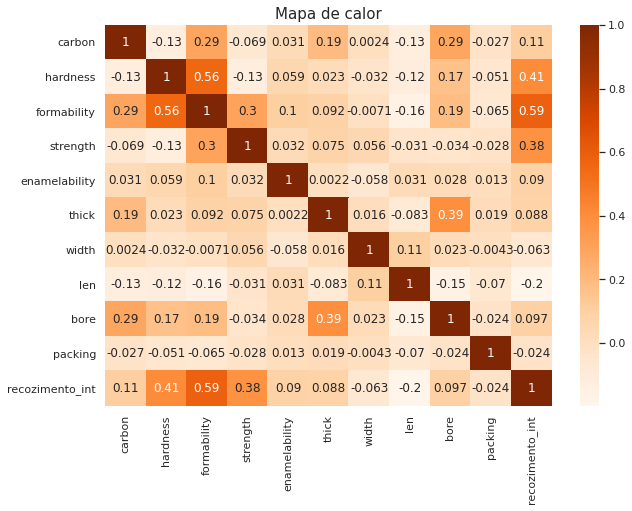

In [76]:


# Correlação de pearson
df_corr = df_new.corr()
plt.figure(figsize=[10,7])
sns.heatmap(df_corr, annot=True, cmap='Oranges')
plt.title('Mapa de calor',fontsize = 15);

Temos que os principais atributos com uma boa correlação positiva aqui são: 'carbon', 'hardness', 'formability' e 'strength'. E o atributo 'len' está para correlação negativa.

Para atributos com variáveis numéricas, essas 5 podem ser as escolhidas. Dependendo de como for a análise de correlação das variáveis categóricas e a distribuição das variáveis numéricas, poderemos excluir da seleção de features os atributos 'carbon' e 'len'.

**Distribuição das variáveis numéricas**

Text(0.5, 1.0, 'Relação entre o atributo de recozimento e as outras variáveis')

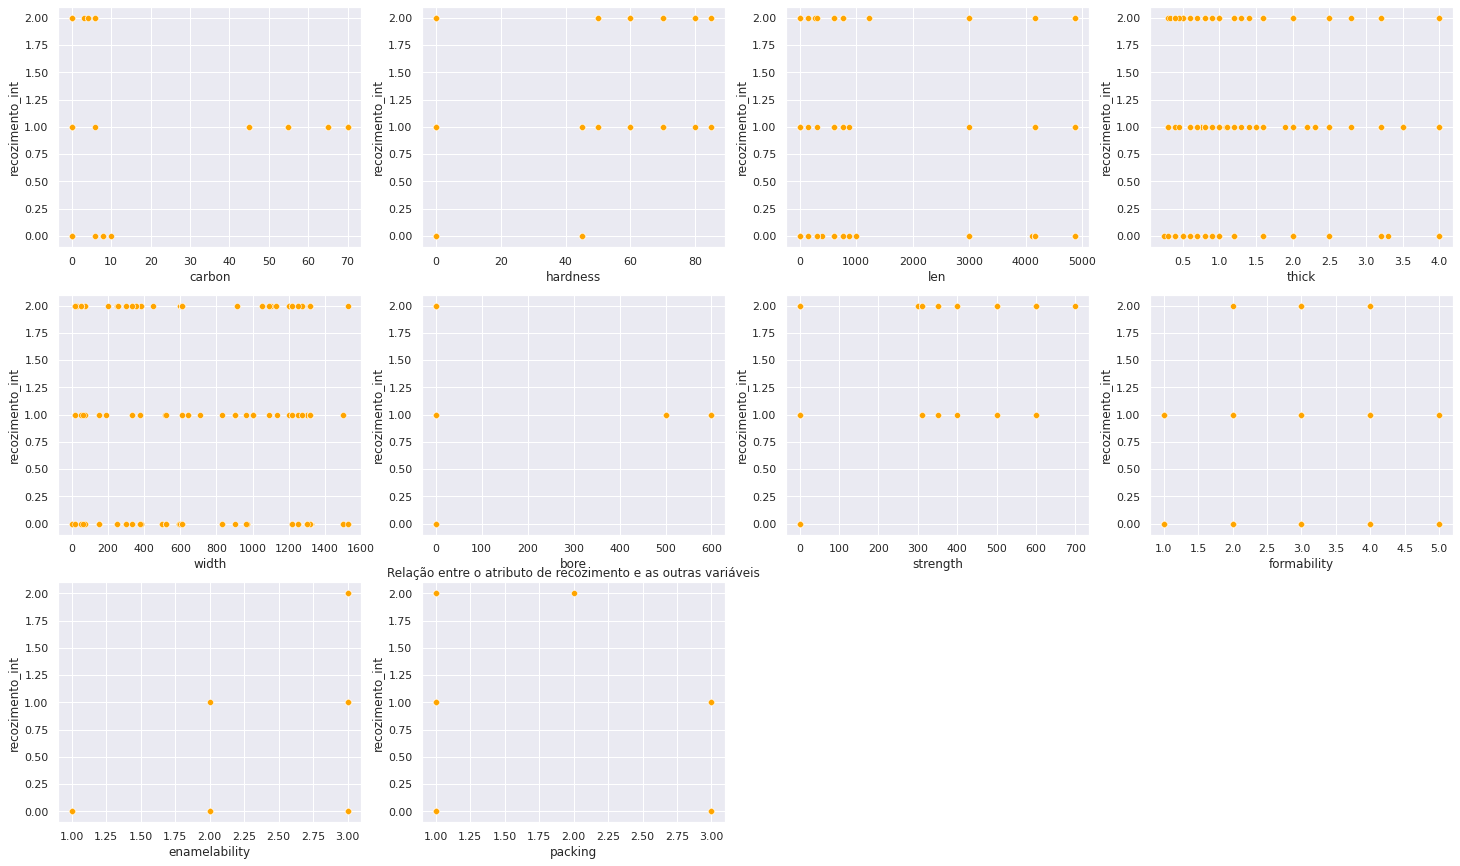

In [77]:
feature_num = ['carbon', 'hardness', 'len', 'thick','width','bore','strength','formability','enamelability','packing']
sns.set()
plt.figure(figsize=[25,15])
for i in range(len(feature_num)):
  j = i+1
  plt.subplot(3,4,j)
  x = feature_num[i]
  sns.scatterplot(data=df_new, x=x, y='recozimento_int', color='orange');
plt.title('Relação entre o atributo de recozimento e as outras variáveis')


Como os atributos 'thick' e 'width' não tiveram boa variabilidade quanto a sua distribuição nas classes preditivas, então pode-se retirar do DataFrame sem causar prejuizo na performance do modelo preditivo:





In [78]:
df_new = df_new.drop(['thick','width'], axis=1)

**Insights levantados até o momento**:

**Hipótese 01**: Dentre os atributos que não foram citados anteriormente, no qual continha uma boa correlação com a variável target, **o atributo 'bore' pode ser um bom indicador para a análise de recozimento mediano**, uma vez que o seu gráfico de dispersão em relação a variável target, demonstra claramente que os valores que foram atribuidos em 500 e 600 se ajustaram bem para o recozimento mediano. (**A hipótese poderá ser validada, ou seja, transformada em insight, com um gráfico de barras que indicará a distribuição de dos dados em relação a variável target**)

**Hipótes 02**: O Atributo 'carbon' também pode ser um ótimo indicador para predizer um recozimento **mediano**, entretanto, não dá para diferenciar em relação a qualidade **ideal** ou **ruim**. (**Poderá ser validada da mesma forma que a hipótese 01**)

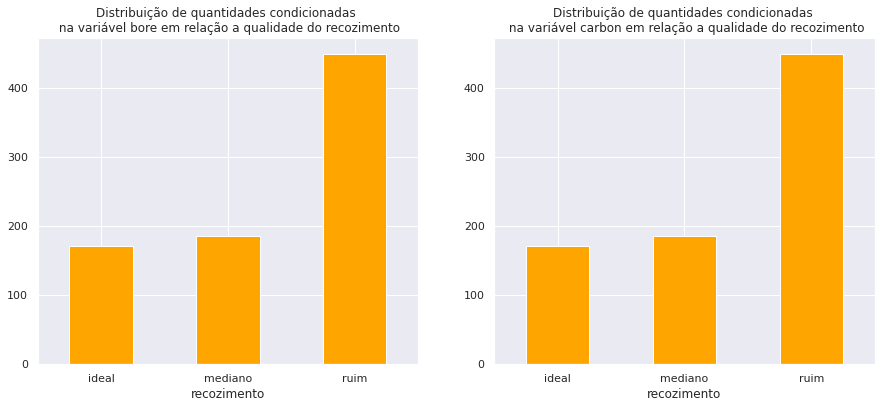

In [79]:
# Hipótese 01 e 02:
sns.set()
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
g = df_new.groupby('recozimento')['bore'].count()
g.plot(kind='bar',color='orange')
plt.title('Distribuição de quantidades condicionadas \n na variável bore em relação a qualidade do recozimento', fontsize=12)
plt.xticks(rotation=0)

plt.subplot(1,2,2)
df_new.groupby('recozimento')['carbon'].count().plot(kind='bar',color='orange')
plt.xticks(rotation=0)
plt.title('Distribuição de quantidades condicionadas \n na variável carbon em relação a qualidade do recozimento', fontsize=12);

Percebe-se que grande parte dos dados estão atribuidos na qualidade de recozimento 'ruim', mas como os dados das outras variáveis estão balanceados, significa que as nossas duas hipóteses estão realmente certas.

Logo, as hipóteses se transformaram em dois insights:
* **INSIGHT 01**: Quanto maior a variável 'bore', maior será a tendência do recozimento ser mediano (**Obs: Para valores acima de 0, todos os experimentos deram qualidade mediana**). Vale ressaltar que para adquirir uma qualidade ideal, os experimentos de recozimento tiveram que ter os valores da variável 'bore' em níveis iguais a zero, e o problema disso é que o nível de qualidade ruim também apareceu nesse valor. **Logo, esse atributo não é um bom parâmetro caso se queira alcançar a condição 'ideal' para a variável de recozimento**.

* **INSIGHT 02**: Quanto maior a variável 'carbon', maior será a tendência do recozimento ser mediano (**Obs: Para valores acima de 10, todos os experimentos deram qualidade mediana**). Entretanto, por motivo semelhante dito no insight 01, caso a prentensão seja avaliar de forma preditiva se o experimento de recozimento será 'ideal', não é aconselhável utilizar esse atributo em modelos preditivos.


In [80]:
# Retirando os atributos ditos nos insights 01 e 02:
df_new = df_new.drop(columns=['carbon','bore'],axis=1)

In [81]:
# Valor máximo para hardness sendo filtrado para qualidade de recozimento ruim
hardness_ruim_max=df_new.loc[df_new['recozimento_int']==0]['hardness'].max()
hardness_ruim_max

45

Um outro insight que pode ser retirado da análise de correlação e da distribuição das variáveis em relação a variável target é:
* **INSIGHT 03**: Quanto maior for as variáveis 'hardness' (**considerando acima de 50 - medida adota com margem de erro para cima em 10% com relação ao limite máximo da variável ruim**)  e 'strength' (**acima de 10, no qual o valor máximo da variável ruim para esse atributo é igual 0**), maior será a probabilidade da qualidade do recozimento ser mediana e ideal.

Caso sejam feita as condições sugeridas, podemos calcular as probalidades das variáveis citadas no insight 03 para a qualidade de recozimento igual ideal. Então, temos que: 

ideal      0.683544
mediano    0.316456
Name: recozimento, dtype: float64
ideal      0.807018
mediano    0.192982
Name: recozimento, dtype: float64


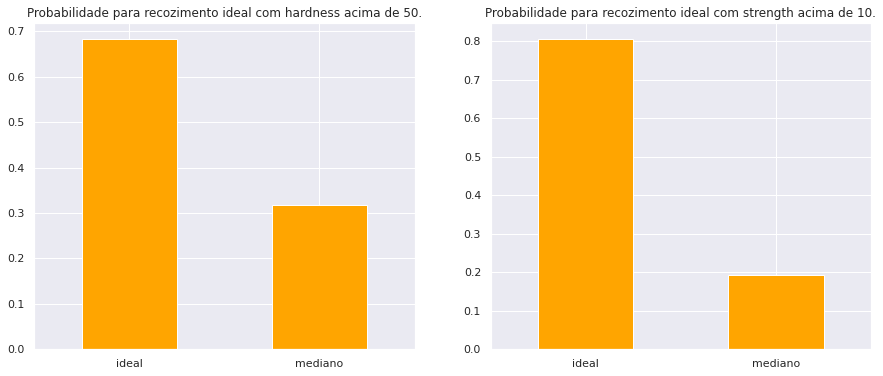

In [82]:
# Probabilidade em 'hardness' acima de 50 para recozimento ideal.
hardness=df_new.loc[df_new['hardness']>50]['recozimento'].value_counts(normalize=True)
print(hardness)
# Probabilidade em 'strength' acima de 10 para recozimento ideal.
strength=df_new.loc[df_new['strength']>10]['recozimento'].value_counts(normalize=True)
print(strength)

# Plotando 
sns.set()
plt.figure(figsize=[15,6])
plt.subplot(1,2,1)
hardness.plot(kind='bar',color='orange')
plt.title('Probabilidade para recozimento ideal com hardness acima de 50.', fontsize=12)
plt.xticks(rotation=0)

plt.subplot(1,2,2)
strength.plot(kind='bar',color='orange')
plt.xticks(rotation=0)
plt.title('Probabilidade para recozimento ideal com strength acima de 10.', fontsize=12);

**Percebe-se que para as condições dadas nos atributos 'hardness' e 'strength', temos que as probabilidade de recozimento ideal para ambas são, respectivamente, 68,35% e 80,7%.**

Como ambos os eventos tem uma relação, que é a taxa de sucesso para o recozimento ideal, podemos aplicar aqui o teorema de Bayes. Utilizando apenas um filtro com ambas as metragens, podemos ter a probabilidade de recozimento ideal. Temos:


In [83]:
# Calculando a probabilidade de sucesso com as duas condições
prob=df_new.loc[df_new['hardness']>50][['recozimento','strength']]
prob.value_counts(normalize=True)

recozimento  strength
ideal        0           0.683544
mediano      0           0.316456
dtype: float64

**INSIGHT 04**: Não existe nenhuma possibilidade nesse banco de dados em que as duas condições sendo satisfeitas, **teria alguma chance de sucesso para o recozimento ideal**.

**INSIGHT 05**: Percebe-se que apesar do atributo 'enamelability' ter pouca correlação com a variável target. **Todos os registros adotados como recozimento ideal, tiveram um valor igua 3 nesse atributo**. Enquanto que o valor adotado no atributo 'formability' **foi de 2,3 e 4**. Tendo essa distribuição:

ideal      0.477663
mediano    0.340206
ruim       0.182131
Name: recozimento, dtype: float64
ruim       0.582677
ideal      0.251969
mediano    0.165354
Name: recozimento, dtype: float64


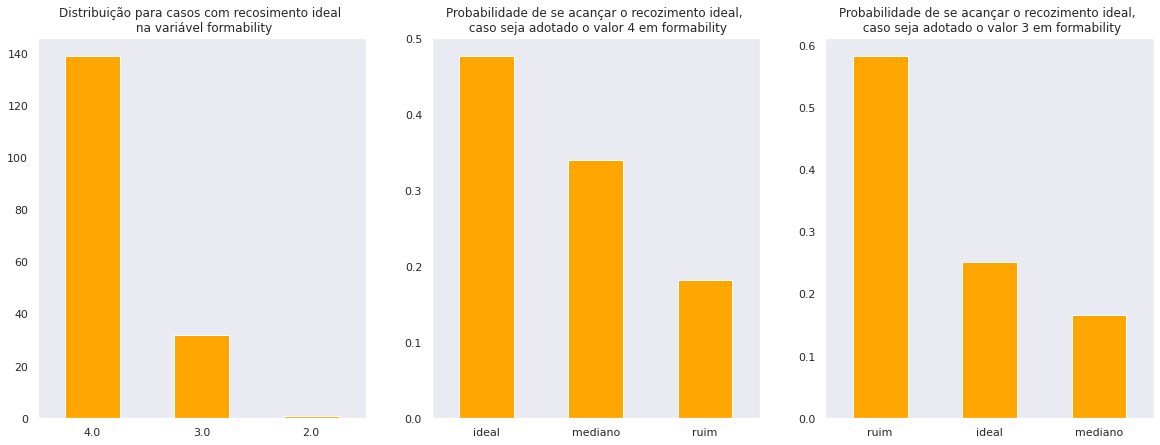

In [84]:
# Distribuição dos experimentos para casos ideais 
sns.set()
plt.figure(figsize=[20,7])
plt.subplot(1,3,1)
df_new.loc[df_new['recozimento_int']==2]['formability'].value_counts().plot(kind='bar',color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.title('Distribuição para casos com recosimento ideal \n na variável formability')

#  Probabilidade de se adotar o valor 4 e der esse resultado
plt.subplot(1,3,2)
df_new.loc[df_new['formability']==4]['recozimento'].value_counts(normalize=True).plot(kind='bar',color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.title('Probabilidade de se acançar o recozimento ideal, \n caso seja adotado o valor 4 em formability')

print(df_new.loc[df_new['formability']==4]['recozimento'].value_counts(normalize=True)) # Medida detalhada

#  Probabilidade de se adotar o valor 3 e der esse resultado
plt.subplot(1,3,3)
df_new.loc[df_new['formability']==3]['recozimento'].value_counts(normalize=True).plot(kind='bar',color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.title('Probabilidade de se acançar o recozimento ideal, \n caso seja adotado o valor 3 em formability');

print(df_new.loc[df_new['formability']==3]['recozimento'].value_counts(normalize=True)) # Medida detalhada


**INSIGHT 06:**Percebe-se que a distribuição de experimentos com recozimento ideal favorece o valor igual a 4, e também há uma maior probabilidade (**47,76%**) em dar o resultado de recozimento ideal. Enquanto que, na escolha do valor igual a 3, a probabilidade de sucesso cai para **25,9%**, e para aumentar ainda mais os riscos, **a probabilidade do recozimento em ser ruim subiu de 18,21% (com valor igual a 4) para 58,27% (com valor igual a 3)**

**INSIGHT 07**: Apesar de que o atributo packing não esteja com uma boa correlação citando como base o mapa de calor, é perceptível que na sua distribuição em relação ás classes preditivas para o valor igual a 2, há uma probabilidade de 100% dos casos em que o recozimento foi considerado ideal.

Para a finalização das análises de variáveis numéricas, podemos demonstrar como os dados da variável target estão balanceados:

ruim       450
mediano    186
ideal      172
Name: recozimento, dtype: int64


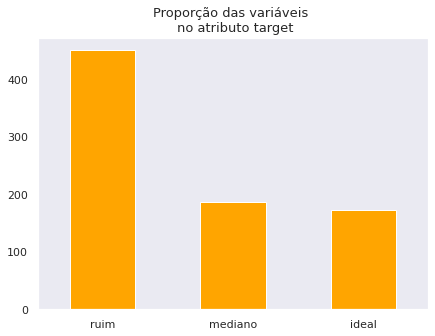

In [85]:
print(df_new['recozimento'].value_counts())
sns.set()
plt.figure(figsize=[7,5])
df_new['recozimento'].value_counts().plot(kind='bar',color='orange')
plt.grid()
plt.title('Proporção das variáveis \n no atributo target', fontsize=13)
plt.xticks(rotation=0);

Percebe-se que os dados estão balanceados nas classes ideal e mediano, mas com uma desproporção no dobro de registros em resultados de recozimento adotados como 'ruim'. **Essa desproporção poderia ser resolvida com a aquisição de mais dados na classe ideal e mediano**.


**OBS**: Esse leve desbalanceamento pode vir a ser motivo de viés, caso não seja tomado os devidos cuidados, como por exemplo a técnica/método utilizado na divisão dos dados em treino e teste. Uma ótima opção de método para essa divisão seria o **cross-validation estratificado**, assim poderia diminuir o risco de qualquer viés, **mas vale ressaltar que o número de k-fold deve ser baixo, devido a pouca quantidade de dados**.

### Análise exploratória para variáveis categóricas


Na seção **Tratamento/Analisando os atributos que contêm '?'**, apesar de que o **ponto 02** sugere uma exclusão das colunas por motivos já explicados, será feita uma análise mais detalhada sobre esses atributos para ver qual podemos escolher como feature para o modelo preditivo. Temos:

**Análise bivariada**: Analisando a composição de classes do recozimento com cada atributo citado no **Ponto 02**

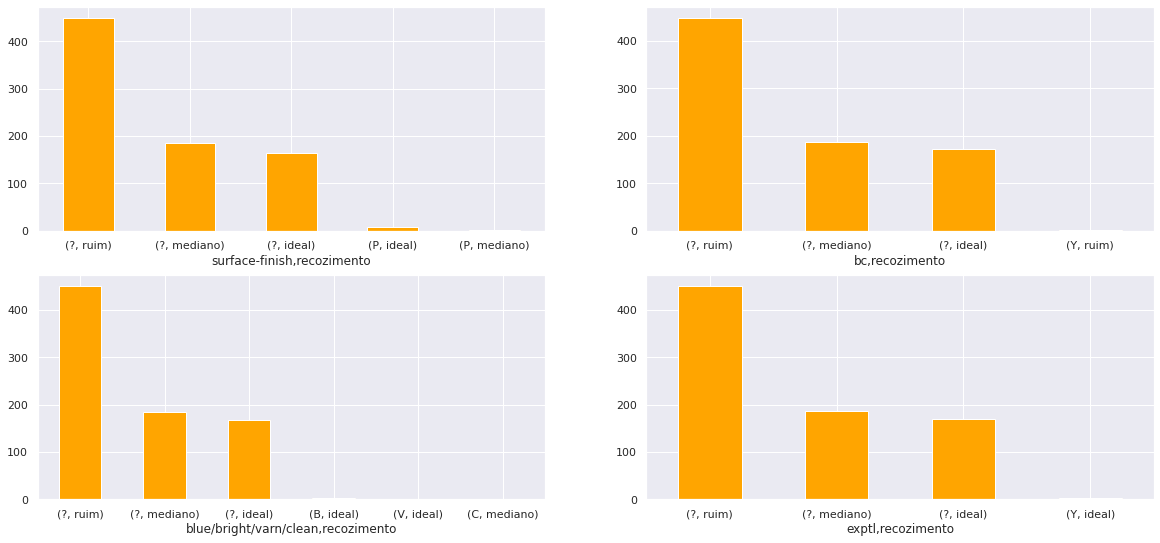

In [86]:
lista = ['surface-finish', 'bc', 'blue/bright/varn/clean', 'exptl']
plt.figure(figsize=[20,14])
for i in range(len(lista)):
  g = df_new[[lista[i],'recozimento']].value_counts()
  k = i + 1
  plt.subplot(3,2,k)
  g.plot(kind='bar',color='orange')
  #plt.title(f'{lista[i]}')
  plt.xticks(rotation=0);



 Pode-se observar que essas variáveis não precisam entrar nas features do modelo, uma vez que as variáveis diferentes de '?' não interfere de maneira incisiva no resultado da target. Temos:
 

In [87]:
# Exclusão das colunas citadas anteriormente
df_new = df_new.drop(['surface-finish', 'bc', 'blue/bright/varn/clean', 'exptl'],axis=1)

Analisando os atributos ditos no **Ponto 03 da seção Tratamento/Analisando os atributos que contêm '?'**, temos que verificar como estão distribuídos os dados para a classe preditiva. Pode-se dizer que é a mesma análise feita anteriormente para as colunas citadas no **Ponto 02**. Temos:


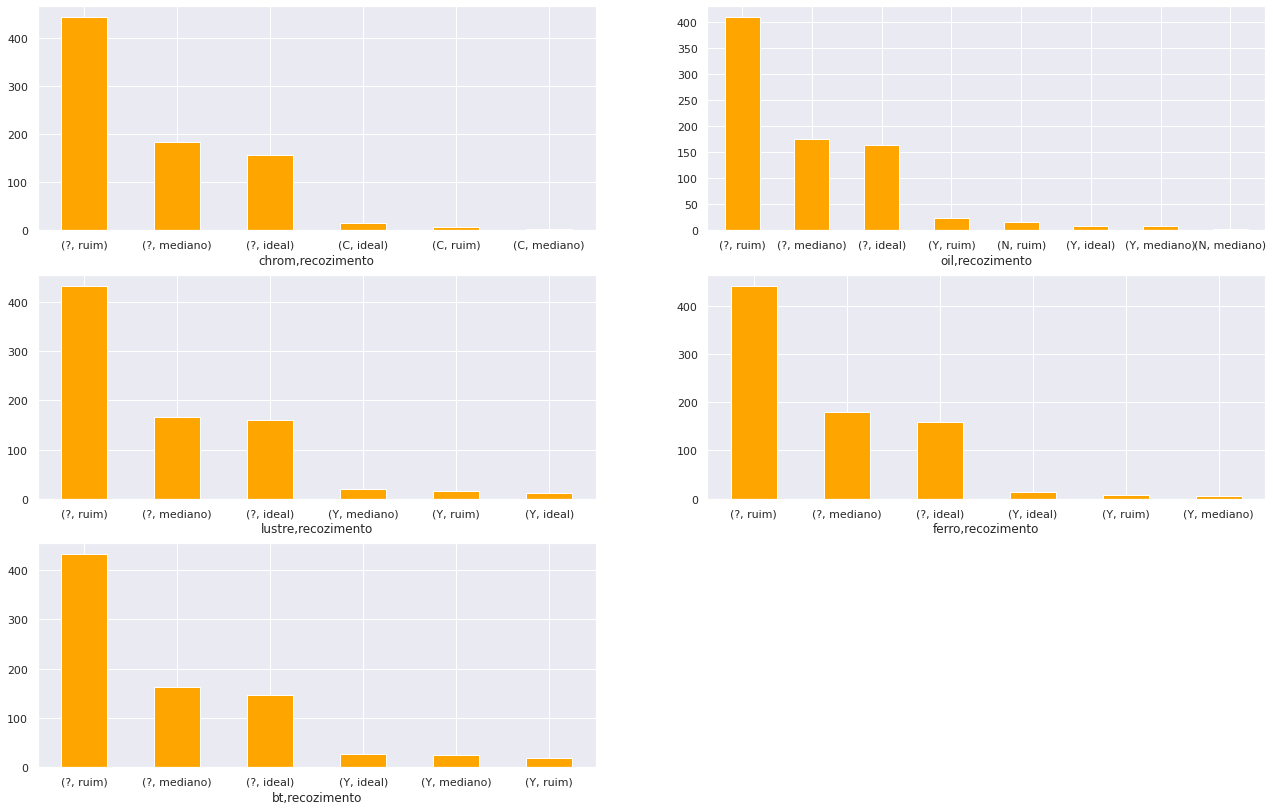

In [88]:
lista=['chrom', 'oil', 'lustre', 'ferro', 'bt']
plt.figure(figsize=[22,14])
for i in range(len(lista)):
  g = df_new[[lista[i],'recozimento']].value_counts()
  k = i + 1
  plt.subplot(3,2,k)
  g.plot(kind='bar',color='orange')
  #plt.title(f'{lista[i]}')
  plt.xticks(rotation=0);

**OBS:**Nas análises referentes aos atributos 'lustr', 'bt', 'ferro' e 'chrom', demonstra-se que a variável 'Y' (ou 'C', no caso do 'chrom') está bem distribuída (balanceada) em cada caso para com as classes referentes á variável target. Logo, percebe-se que não há muitos riscos em se excluir esses atributos do DataFrame.

**INSIGHT 08:** Percebe-se que não há recozimento ideal quando a variável do atributo 'oil' se iguala a N. Mas como temos poucos dados, isso não é uma verdade absoluta, mas é notável que o nosso modelo pode adquirir esse viés. E isso pode ser perigoso, já que não temos muitos dados para ter uma efetiva comprovação. Logo, podemos nos arriscar também a excluir essa coluna.

In [89]:
# Exclusão de colunas 
df_new = df_new.drop(['lustre', 'bt', 'ferro', 'chrom','oil'],axis=1)

Quantidade de atributos restantes:


In [90]:
df_new.shape

(808, 21)

In [91]:
df_new.columns

Index(['family', 'product-type', 'steel', 'hardness', 'temper_rolling',
       'condition', 'formability', 'strength', 'non-ageing', 'surface-quality',
       'enamelability', 'bf', 'bw/me', 'bl', 'phos', 'cbond', 'shape', 'len',
       'packing', 'recozimento', 'recozimento_int'],
      dtype='object')

Analisando os atributos categóricos faltantes, temos:


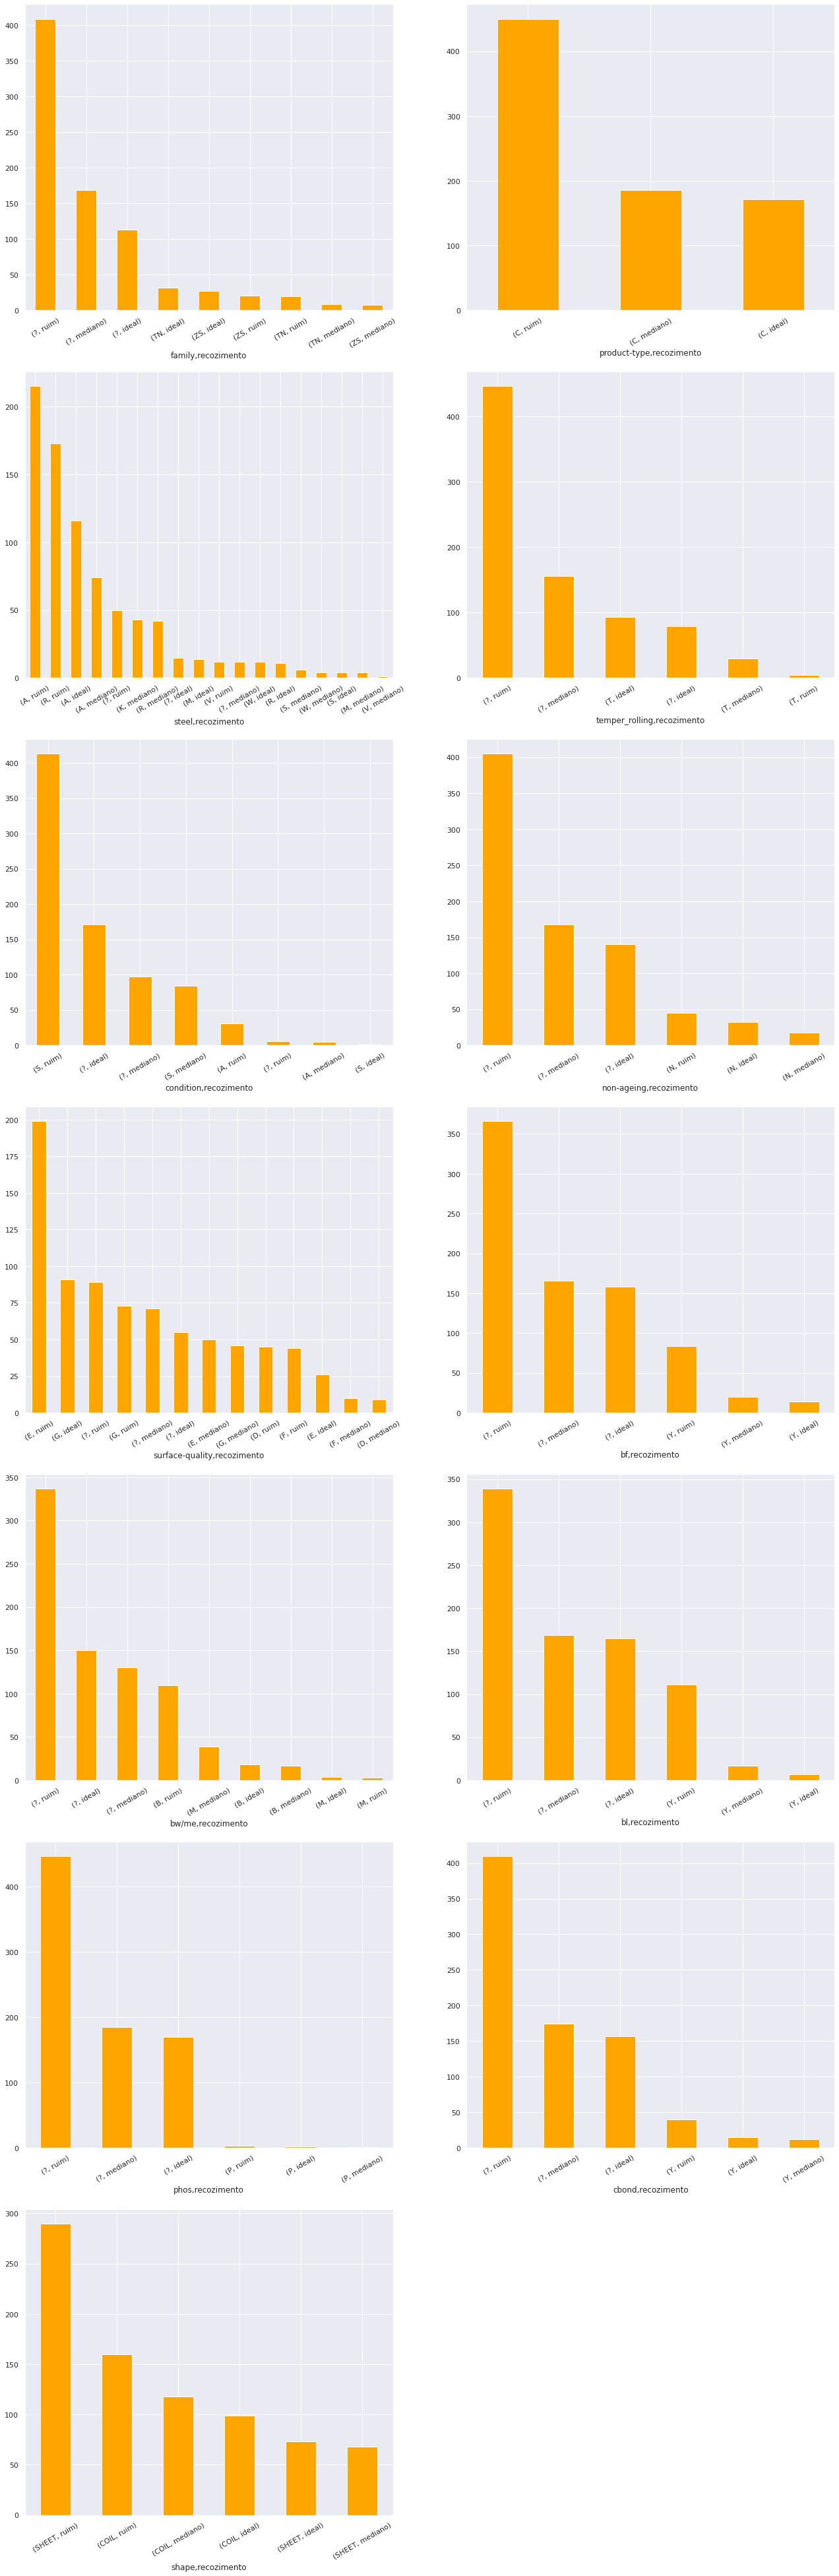

In [92]:
lista = ['family', 'product-type', 'steel','temper_rolling',
       'condition','non-ageing', 'surface-quality','bf', 
       'bw/me', 'bl', 'phos', 'cbond', 'shape']

plt.figure(figsize=[22,70])
for i in range(len(lista)):
  g = df_new[[lista[i],'recozimento']].value_counts()
  k = i + 1
  plt.subplot(7,2,k)
  g.plot(kind='bar',color='orange')
  plt.xticks(rotation=30);

**Ponto 07:** Os atributos 'family','steel', 'bw/me', 'bl', 'phos', 'non-ageing', 'cbond', 'surface-quality' e 'shape' se assemelham quanto a distribuição das classes preditivas ditas em **ruim** e **ideal** nas variáveis de cada atributo, sendo que essa uniformidade acaba não nos mostrando um caminho claro para a escolha de alguma dessas classes como preditora. Logo, elas podem ser retiradas do Dataset.

**Ponto 08:** Devido também a uniformidade das respostas da variável target (**ideal, mediano e ruim**) em relação as colunas 'product-type' e 'bf', podemos retirá-la sem perda de performance do modelo preditivo.

**INSIGHT 09:** As colunas 'temper_rolling' e 'conditions' têm uma boa variabilidade entre o conjunto de classes da variável target. Na análise do primeiro atributo, podemos perceber que **quando a variável tem o valor de T, grandes são as chances da variável resposta ser ideal ou mediano**. E na análise do segundo atributo, podemos perceber qua **para valores da variável preditora iguais a '?', maiores são as chances da variável resposta ser ideal ou mediana.**

Realizando cálculo para a propabilidade sucessos (**recozimento ideal** - margem de segurança, uma vez que não inclui a variável mediano) preditos no insight 09, temos:

ideal      0.732283
mediano    0.236220
ruim       0.031496
Name: recozimento, dtype: float64
ideal      0.624088
mediano    0.354015
ruim       0.021898
Name: recozimento, dtype: float64


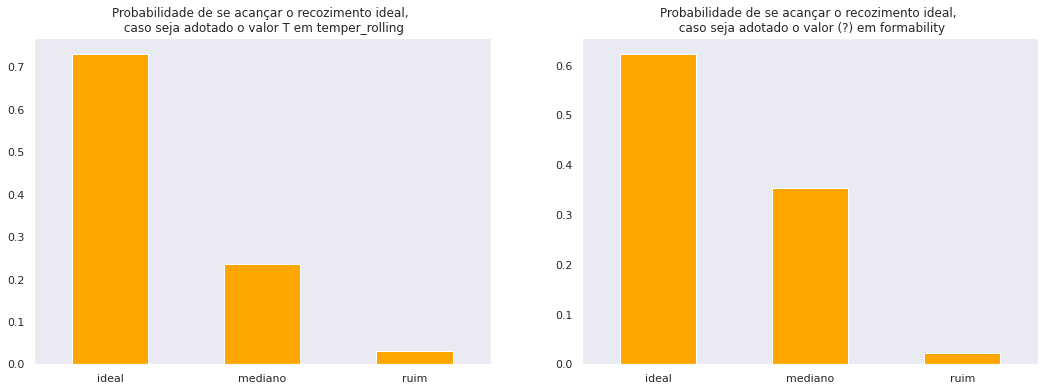

In [93]:
#  Probabilidade de se adotar o valor T para dar como resuldato o ideal
plt.figure(figsize=[18,6])
plt.subplot(1,2,1)
df_new.loc[df_new['temper_rolling']=='T']['recozimento'].value_counts(normalize=True).plot(kind='bar',color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.title('Probabilidade de se acançar o recozimento ideal, \n caso seja adotado o valor T em temper_rolling')

print(df_new.loc[df_new['temper_rolling']=='T']['recozimento'].value_counts(normalize=True)) # Medida detalhada

#  Probabilidade de se adotar o valor ? para dar como resultado o ideal
plt.subplot(1,2,2)
df_new.loc[df_new['condition']=='?']['recozimento'].value_counts(normalize=True).plot(kind='bar',color='orange')
plt.grid()
plt.xticks(rotation=0)
plt.title('Probabilidade de se acançar o recozimento ideal, \n caso seja adotado o valor (?) em formability');

print(df_new.loc[df_new['condition']=='?']['recozimento'].value_counts(normalize=True)) # Medida detalhada

**Complemento para o INSIGHT 9:** No primeiro atributo, a probalidade de se alcançar o recozimento ideal é **73,2%** para a condição adotada, e para o segundo atributo, a probabilidade de acontecer o recozimento ideal para a condição adotada é de **62,4%**. Logo, temos que ambas as probabilidades são boas, ainda mais porque a taxa de falha (**recozimento considerado ruim**) é de **3,14%** para o primeiro atributo, e **2,2%** para o segundo atributo. Então, temos uma boa margem de segurança, porque somando as probabilidades de acontecer um recozimento **ideal ou mediano** é de, aproximadamente, **96,8%** com margem de erro em 0,2%.

Exclusão das colunas que foram julgadas desnecessárias:


In [94]:
df_new = df_new.drop(['family','steel', 'bw/me', 'bl', 'phos', 'non-ageing', 'cbond', 'surface-quality', 'shape', 'product-type', 'bf' ],axis=1)


Visualizando a nova quantidade de atributos:

In [95]:
df_new.shape

(808, 10)

In [96]:
df_new.columns

Index(['hardness', 'temper_rolling', 'condition', 'formability', 'strength',
       'enamelability', 'len', 'packing', 'recozimento', 'recozimento_int'],
      dtype='object')

## Pré-Processamento

---
Nessa etapa, vamos mapear os atributos categóricos com a técnica mais apropriada para cada tipo de variável, e em seguida, iremos fazer a normalização dos nossos dados numéricos para um melhor desempenho em algoritmos de classificação baseados em distâncias e para que o algoritmo não se torne enviesado para valores maiores.

**Sugestão**
* Se a variável qualitativa for do tipo categórica, poderemos utilizar a técnica Label Encoding. (A ordem interessa!)
* Se a variável qualitativa for do tipo nominal, poderemos utilizar a técnica One-Hot-Encoding, e que apesar de ser uma boa técnica de mapeamento, pode agravar o efeito da mal dimensionalidade na performance do modelo preditivo, uma vez que aumentará o número de atributos por causa do processo de vetorização.

**Como não sabemos com qual tipo de variável qualitativa estamos lidando, temos que fazer testes com cada tipo de técnica**


**Variáveis categóricas**

Como foi dado pouco tempo para fazer esse projeto (desafio), adotaremos aquela que for mais conveniente no momento que é a label encoding, e a resposta para a solução que estamos propondo **é por causa da pouca quantidade de dados disponíveis, e como já temos muitos atributos, agravaria o efeito da mal dimensionalidade caso fosse criado mais Features com a técnica de one-hot encoding**.

In [97]:
# Observando quais são as variáveis existentes nos atributos qualitativos
print(df_new['condition'].value_counts())
print(df_new['temper_rolling'].value_counts())

S    498
?    274
A     36
Name: condition, dtype: int64
?    681
T    127
Name: temper_rolling, dtype: int64


In [98]:
# Mapeamento das variáveis categóricas
c = {'S':0,'?':1, 'A':2}
t = {'?':0,'T':1}
df_new['condition']=df_new['condition'].map(c)
df_new['temper_rolling']=df_new['temper_rolling'].map(t)

**Variável numérica**

Podemos Normalizar, no qual os valores estariam entre 0 e 1, ou padronizar, transformando a média em 0 e a distância para cada ponto seria de acordo com o desvio padrão. **Para escolher a técnica mais apropriada, vamos analisar as distribuições das variáveis numéricas. O ideal seria avaliar a partir dos resultados obtidos.**

In [99]:
lista=['hardness', 'formability', 'strength',
       'enamelability', 'len', 'packing']

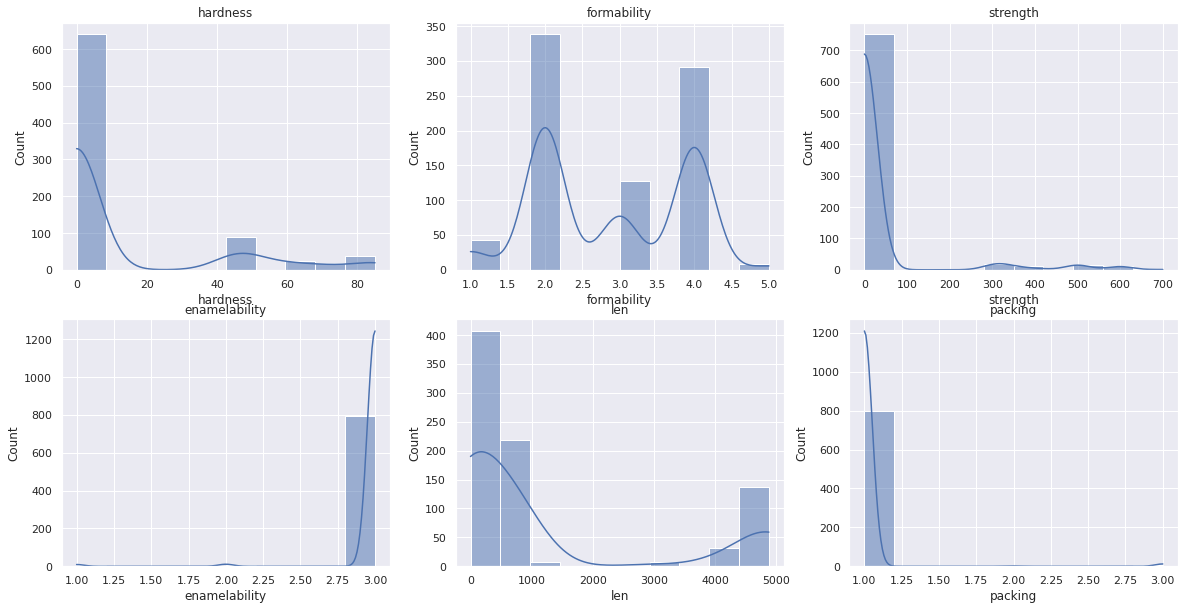

In [100]:
sns.set()
plt.figure(figsize=[20,10])
for i in range(len(lista)):
  j = i+1
  plt.subplot(2,3,j)
  sns.histplot(data=df_new,x=f'{lista[i]}',bins=10,kde=True)
  plt.title(f'{lista[i]}')


**Identificando os outliers pelo boxplot**

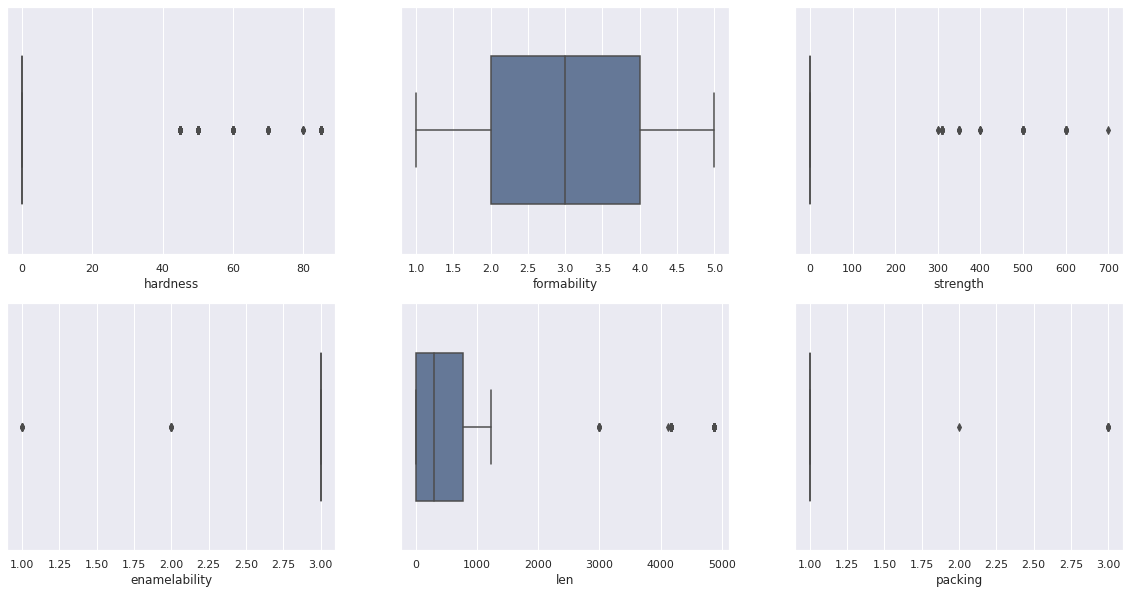

In [101]:
sns.set()
plt.figure(figsize=[20,10])
for i in range(len(lista)):
  j = i+1
  plt.subplot(2,3,j)
  sns.boxplot(data=df_new, x=f'{lista[i]}', width=0.6, saturation=0.5,orient='h');

**Devido a alguns outliers, vamos adotar a normalização**

In [102]:
df_new.columns

Index(['hardness', 'temper_rolling', 'condition', 'formability', 'strength',
       'enamelability', 'len', 'packing', 'recozimento', 'recozimento_int'],
      dtype='object')

In [103]:
df_new.iloc[:,:9]

,hardness,temper_rolling,condition,formability,strength,enamelability,len,packing,recozimento
0,0,0,0,4.0,0,3.0,0.0,1.0,ruim
1,0,0,0,2.0,0,3.0,762.0,1.0,ruim
2,60,1,1,4.0,0,3.0,0.0,1.0,ideal
3,60,1,1,4.0,0,3.0,269.0,1.0,ideal
4,45,0,0,4.0,0,3.0,0.0,1.0,mediano
...,...,...,...,...,...,...,...,...,...
803,0,0,0,2.0,0,3.0,4170.0,1.0,mediano
804,0,0,1,3.0,0,3.0,1.0,1.0,ideal
805,0,0,0,3.0,0,3.0,880.0,1.0,mediano
806,85,1,1,4.0,0,3.0,0.0,1.0,ideal


In [104]:
# Extraindo as matrizes x e y ( Transformando colunas do DataFrame em array)
x = np.array(df_new.drop(['recozimento','recozimento_int'],axis=1))
y= np.array(df_new['recozimento_int'])

In [105]:
# Normalizando a variável preditora
norm = MinMaxScaler()
x = norm.fit_transform(x)

## Treino e validação do modelo de ML

---
Serão utilizados 3 algoritmos de Machine Learning: RandomForest, SVM (Support Vector Machine) e KNN.

**MÉTODO DE AVALIAÇÃO:** Nesse contexto de negócio, o que importa é a taxa de acerto com o que o modelo preditivo realiza a classificação. Ou seja, qual a probabilidade em dar o resultado da qualidade de recozimento (**ideal, mediano ou ruim**) correto de acordo com as features selecionadas. Logo, estaremos adotando a **acurácia** do modelo como método de avaliação.


**Divisão estratificada de treino e teste**

Essa abordagem, como falada anteriormente, foi escolhida para gerar mais segurança no momento de divisão dos dados, ao saber que os dados serão divididos e avaliados de forma proporcional, diminuindo qualquer viés. Como são poucos dados, utilizaremos o número de k-fold (iterações e agrupamentos) igual a 3, e como os dados não estão tão desbalanceados, esse é um valor que aparenta se adequar (**em condições ideais, seria necessário fazer alguns testes**).

**Random Forest**


---
Para todos os modelos, serão avaliados o Recall, acurácia, precisão e o F-1.


In [106]:
classifier_cv = RandomForestClassifier(n_estimators= 10, random_state=42)

cv_strat = StratifiedKFold(n_splits = 3)

scores_cv_strat = cross_val_score(classifier_cv, x, y, cv=cv_strat)
scores_cv_strat_precision = cross_val_score(classifier_cv, x, y, cv=cv_strat, scoring='precision_macro')
scores_cv_strat_recall = cross_val_score(classifier_cv, x, y, cv=cv_strat, scoring='recall_macro')
scores_cv_strat_f1 = cross_val_score(classifier_cv, x, y, cv=cv_strat, scoring='f1_macro')

print("Acurácia: %0.2f (+/- %0.2f)" % (scores_cv_strat.mean(), scores_cv_strat.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_cv_strat_precision.mean(), scores_cv_strat_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_cv_strat_recall.mean(), scores_cv_strat_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores_cv_strat_f1.mean(), scores_cv_strat_f1.std() * 2))

Acurácia: 0.80 (+/- 0.02)
Precision: 0.75 (+/- 0.05)
Recall: 0.72 (+/- 0.02)
F1: 0.70 (+/- 0.04)


**KNN**

In [107]:
knn = KNeighborsClassifier()
scores_knn_strat = cross_val_score(knn, x, y, cv=cv_strat)
scores_knn_strat_precision = cross_val_score(knn, x, y, cv=cv_strat, scoring='precision_macro')
scores_knn_strat_recall = cross_val_score(knn, x, y, cv=cv_strat, scoring='recall_macro')
scores_knn_strat_f1 = cross_val_score(knn, x, y, cv=cv_strat, scoring='f1_macro')

print("Acurácia: %0.2f (+/- %0.2f)" % (scores_knn_strat.mean(), scores_cv_strat.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_knn_strat_precision.mean(), scores_cv_strat_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_knn_strat_recall.mean(), scores_cv_strat_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores_knn_strat_f1.mean(), scores_cv_strat_f1.std() * 2))


Acurácia: 0.79 (+/- 0.02)
Precision: 0.77 (+/- 0.05)
Recall: 0.72 (+/- 0.02)
F1: 0.70 (+/- 0.04)


**SVM**


In [108]:
svm = SVC()
scores_svm_strat = cross_val_score(svm, x, y, cv=cv_strat)
scores_svm_strat_precision = cross_val_score(svm, x, y, cv=cv_strat, scoring='precision_macro')
scores_svm_strat_recall = cross_val_score(svm, x, y, cv=cv_strat, scoring='recall_macro')
scores_svm_strat_f1 = cross_val_score(svm, x, y, cv=cv_strat, scoring='f1_macro')

print("Acurácia: %0.2f (+/- %0.2f)" % (scores_svm_strat.mean(), scores_cv_strat.std() * 2))
print("Precision: %0.2f (+/- %0.2f)" % (scores_svm_strat_precision.mean(), scores_cv_strat_precision.std() * 2))
print("Recall: %0.2f (+/- %0.2f)" % (scores_svm_strat_recall.mean(), scores_cv_strat_recall.std() * 2))
print("F1: %0.2f (+/- %0.2f)" % (scores_svm_strat_f1.mean(), scores_cv_strat_f1.std() * 2))

Acurácia: 0.79 (+/- 0.02)
Precision: 0.74 (+/- 0.05)
Recall: 0.70 (+/- 0.02)
F1: 0.69 (+/- 0.04)


In [111]:
# mapeando a acurácia de cada modelo
mape = {'RandomForest':scores_cv_strat.mean(),
        'SVM':scores_svm_strat.mean(),
        'KNN':scores_knn_strat.mean()}
    
acuracia = pd.DataFrame(mape,index=[0])
acuracia

,RandomForest,SVM,KNN
0,0.797049,0.790862,0.794552


Percebe-se que o melhor modelo no momento foi o Random Forest, apesar de todos estarem quase sobre a mesma medida. 

**Sugestão:** Para melhorar ainda mais os modelos preditivos, poderíamos fazer a sintonização dos seus hiperparâmetros, e avaliar com mais métricas para entender melhor a performance de cada modelo.

**Salvar o modelo para o Deploy**

In [112]:
# salvar modelo
import pickle

# salvar o modelo RandomForest (classifier_cv) no arquivo randomforest.pkl
with open('randomforest.pkl', 'wb') as file:
    pickle.dump(classifier_cv, file)